## mrjob

Here's a simple demonstration of mrjob. We will take user data from the Yelp Challenge Dataset, get the social network data, and write a mapreduce to find which friends each pair of users has in common.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np

In [2]:
df = pd.read_csv("../../yelp_challenge/yelp_academic_dataset_user.csv")

In [3]:
df.head(1)

,yelping_since,compliments.plain,review_count,friends,compliments.cute,compliments.writer,fans,compliments.note,type,compliments.hot,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,25,108,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",15,9,69,20,user,48,...,3,"[2005, 2006]",Russel,18kPq7GPye-YQ3LyKyAZPw,245,NaN,166,15,11,278


For our purposes we only need "user_id" and "friends", so let's remove everything else. It's nice to know the distribution of number of friends as well.

In [ ]:
cdf = df[["user_id","friends"]]
cdf["num_friends"] = cdf.friends.apply(lambda x: len(x.split()))
d = dict(zip(cdf.user_id, range(len(cdf))))
cdf.user_id = cdf.user_id.apply(lambda x: d[x])
cdf.friends = cdf.friends.apply(lambda x: [d[i] for i in ast.literal_eval(x)])

In [5]:
cdf.head()

,user_id,friends,num_friends
0,0,"[1, 2, 3, 5, 6, 12, 93, 454, 1083, 1348, 1434,...",206
1,1,"[0, 2, 3, 4, 5, 7, 9, 729, 12, 90, 91, 93, 178...",1904
2,2,"[0, 1, 7, 9, 10, 93, 178, 455, 545, 546, 1083,...",354
3,3,"[0, 1, 1083, 53097]",4
4,4,"[1, 12, 16522, 13118]",4


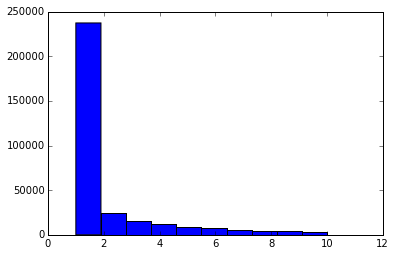

In [6]:
p = plt.hist(cdf.num_friends, range=(1, 10))

In [7]:
np.mean(cdf.num_friends)

7.5502774634252754

As we might expect, most people have very few friends, but there are a few people who spread the curve right. To make things a little more social, let's just take the users on Yelp with at least 5 friends.

In [8]:
social = cdf[cdf.num_friends >= 5]
social = social[["user_id", "friends"]]

Finally, we set up our mapreduce routine with mrjob.

The key here is the following: suppose we have two people A and B, and their friends are as follows:

* A --> [B, C, D, G]
* B --> [A, D, E, F]

Then the mutual friends are just the people who are in both groups (D).

In [10]:
from mrjob.job import MRJob
import mrjob
from mrjob.step import MRStep
import ast
from collections import defaultdict

class MR_mutual_friends(MRJob):

    INTERNAL_PROTOCOL = mrjob.protocol.PickleProtocol
    pairs = defaultdict(set)

    def mapper(self, _, friends):
        # for each user, make pairs with each friend
        # and use as a value the user's whole friend list
        # the semicolons are a result of csv formatting
        u = ast.literal_eval(friends.split(";")[0])
        fr = ast.literal_eval(friends.split(";")[1])
        for f in fr:
            yield (u, f), fr

    def combiner(self, pair, friends):
        # keep a set for each pair, and every time a new friend appears, 
        # add that friend to the set
        # otherwise if the friend already exists, we know it is mutual
        p = tuple(sorted(pair))
        if p not in self.pairs:
            self.pairs[p] = set()
        for f in list(friends)[0]:
            if f not in self.pairs[p]:
                self.pairs[p].add(f)
            else:
                yield p, f

    def reducer(self, pair, friends):
        # finally, just return the list of mutual friends
        # or use len(list(friends)) to return the number
        yield pair, friends

#if __name__ == '__main__':
#    MR_mutual_friends.run()


And that's it! This can't really be run from an IPython Notebook, but on the command line it's as simple as:
* python MR_mutual_friends.py yelp_data.csv > mutualfriends.txt